# Task 1: Classification

**Student Name:** Jason Coleman

**Student ID:** 9539719

1. Open a new Jupyter notebook and name it etivity3_classification.ipynb. 
2. In this notebook, first of all, replace the column `insurance_cost` with a binary column `insurance_cost_binary`, where `insurance_cost_binary` is 0 if the corresponding `insurance_cost` is less than or equal to the median insurance cost and 1 otherwise. 
3. Then train three classification pipelines with:

    - SVM, 
    - Random Forest and 
    - a third classifier of your choice as the final estimator, respectively, to train a model that predicts the value of `insurance_cost_binary`. 

**Requirements:**

- For each classifier, include data preparation and dimensionality reduction steps in the main pipeline.
- You can choose any classifier as the third one. Some options are MLPClassifier, Naive Bayes, and kNN, but you are not limited to them.
- For the dimensionality reduction step use PCA, RFE and a third dimensionality reduction (incl. feature selection) technique in at least one pipeline.
- Use grid search for hyperparameter tuning and replicate the process in the example notebook Tutorial 3-1 - Binary Classification.ipynb to evaluate and compare the models you have trained and pick the best one.
- Summarise your experience in a markdown cell (max 150 words in a markdown cell).

[Rubrik](https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=17939&rubricId=1755&originTool=quicklinks)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import RFE, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support, classification_report
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

%matplotlib inline

In [2]:
# I use Ipython to better format the outputs. You may need to install.
# %pip install ipython

### Utility

In [3]:
from IPython.display import Markdown

def generate_markdown_table(params_list):
    # Determine the longest dictionary for column width
    longest_dict = max(params_list, key=len)
    headers = longest_dict.keys()
    
    # Start building the Markdown output
    markdown_output = "| " + " | ".join(headers) + " |\n"
    markdown_output += "| " + " | ".join(['---' * len(header) for header in headers]) + " |\n"
    
    # Fill in rows with parameter values
    for params in params_list:
        row = "| "
        for header in headers:
            # Add each parameter value to the row, handle missing keys with a default
            row += str(params.get(header, "N/A")) + " | "
        markdown_output += row + "\n"
    
    return markdown_output

def display_bold_text(text):
    display(Markdown(f"**{text}**"))

In [4]:
import warnings 
# I do the following knowingly as some 
# fits failed (and long warnings make 
# GitLab jupyter reviews painful).
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


## EDA - Exploratory Data Analysis

In [5]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [6]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

In [7]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

There are no missing values. Let's check the boxplots of the numerical columns for outliers. We do this in three slices.

In [8]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

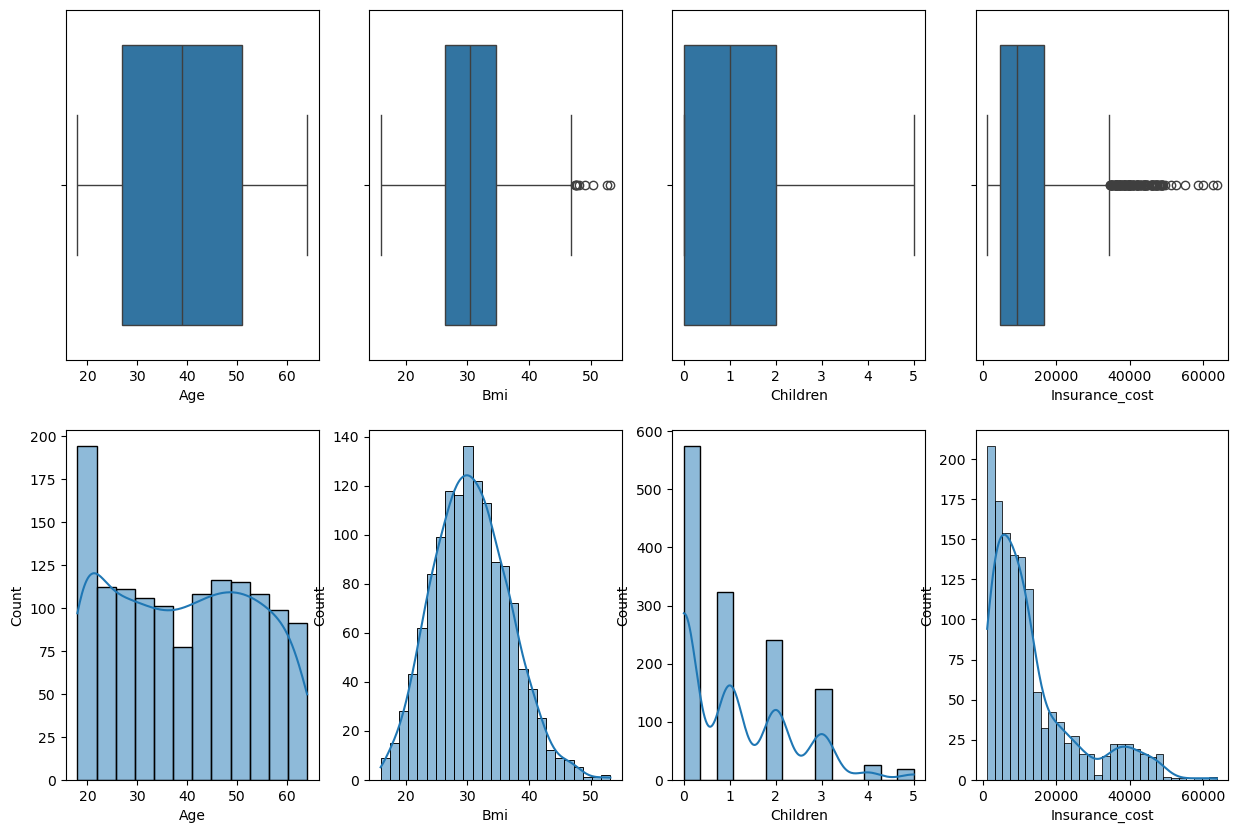

In [9]:
columns_to_plot = ['age', 'bmi', 'children', 'insurance_cost']

plt.figure(figsize=(15, 10))

for index, column in enumerate(columns_to_plot, start=1):
    plt.subplot(2, len(columns_to_plot), index)  # Create a subplot in the first row
    sns.boxplot(x=df[column])  # Create the boxplot for the column
    plt.xlabel(column.capitalize())  # Set the x-axis label with capitalized column name

for index, column in enumerate(columns_to_plot, start=1):
    plt.subplot(2, len(columns_to_plot), len(columns_to_plot) + index)  
    sns.histplot(df[column], kde=True) 
    plt.xlabel(column.capitalize())  

plt.show()

* `age` is almost uniform, with some outliers in the 0-20 age group. 
* `bmi` is almost normal in terms of distribution
* `children` is right skewed
* `insurance_cost` is right-skewed and has outliers (but this will likely be dropped)

Visualise 'region', 'gender' and 'smoker' columns in a grid

<Axes: title={'center': 'Smoker'}>

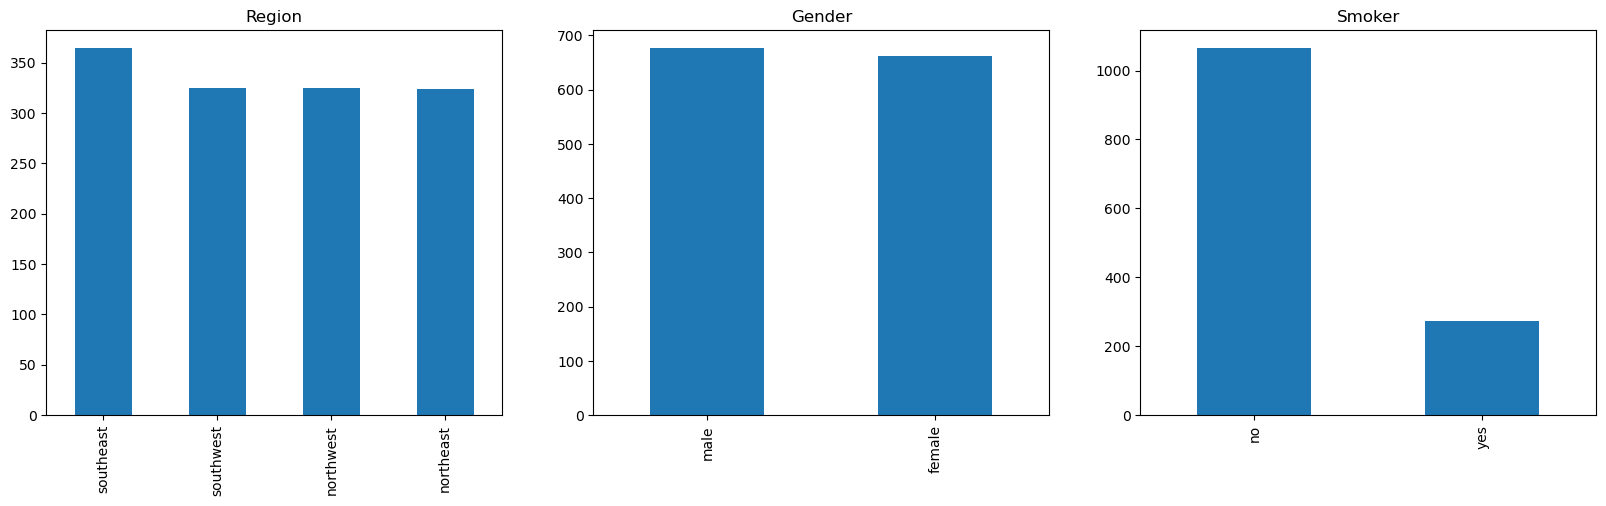

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
df['region'].value_counts().plot(kind='bar', ax=ax[0], title='Region')
df['gender'].value_counts().plot(kind='bar', ax=ax[1], title='Gender' )
df['smoker'].value_counts().plot(kind='bar', ax=ax[2], title='Smoker')

* `Region` - we have a nice balance of regions
* `Gender` - we have a nice balance of gender
* `Smoker` - we have an imbalance in the ratio of people who smoke to those who do not.

Highlight columns that have zero values

In [11]:
df.isin([0]).sum()

age                 0
gender              0
bmi                 0
children          574
smoker              0
region              0
insurance_cost      0
dtype: int64

Look at how much each attribute correlates with the insurance_cost attribute.

In [12]:
corr_matrix = df.corr(numeric_only=True)

corr_matrix["insurance_cost"].sort_values(ascending=False)

insurance_cost    1.000000
age               0.299008
bmi               0.198341
children          0.067998
Name: insurance_cost, dtype: float64

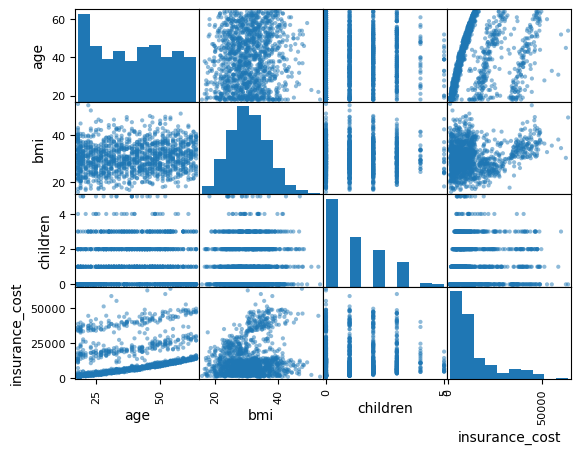

In [13]:
from pandas.plotting import scatter_matrix

attributes = ["age", "bmi", "children", "insurance_cost"]

scatter_matrix(df[attributes])
plt.show()

Looks like `insurance_cost` increases with `age` (not a surprise). Similar trend with `bmi`.

**Question:** Does smoking impact insurance cost?

Mean cost of insurance, grouped by whether they smoke or not.

In [14]:
df.groupby('smoker')['insurance_cost'].mean()

smoker
no      8434.268298
yes    32050.231832
Name: insurance_cost, dtype: float64

**Ans:** Yes. Significantly.

**Question:** Does gender impact insurance cost?

In [15]:
df.groupby('gender')['insurance_cost'].mean()

gender
female    12569.578844
male      13956.751178
Name: insurance_cost, dtype: float64

**Ans:** Not significantly

**Question:** Does region impact insurance cost?

In [16]:
df.groupby('region')['insurance_cost'].mean()

region
northeast    13406.384516
northwest    12417.575374
southeast    14735.411438
southwest    12346.937377
Name: insurance_cost, dtype: float64

**Ans:** 

* NW and SW are closer in cost. 
* NE is a little higher than NW and SW 
* SE is a little more expensive than all regions (is this the UuK - if so, might make sense as this is where London is). 

**Question:** Does #children impact insurance cost?

In [17]:
df.groupby('children')['insurance_cost'].describe()

count          mean           std        min          25%  \
children                                                              
0         574.0  12365.975602  12023.293942  1121.8739  2734.421150   
1         324.0  12731.171832  11823.631451  1711.0268  4791.643175   
2         240.0  15073.563734  12891.368347  2304.0022  6284.939438   
3         157.0  15355.318367  12330.869484  3443.0640  6652.528800   
4          25.0  13850.656311   9139.223321  4504.6624  7512.267000   
5          18.0   8786.035247   3808.435525  4687.7970  5874.973900   

                  50%           75%          max  
children                                          
0          9856.95190  14440.123825  63770.42801  
1          8483.87015  15632.052050  58571.07448  
2          9264.97915  20379.276748  49577.66240  
3         10600.54830  19199.944000  60021.39897  
4         11033.66170  17128.426080  40182.24600  
5          8589.56505  10019.943975  19023.26000

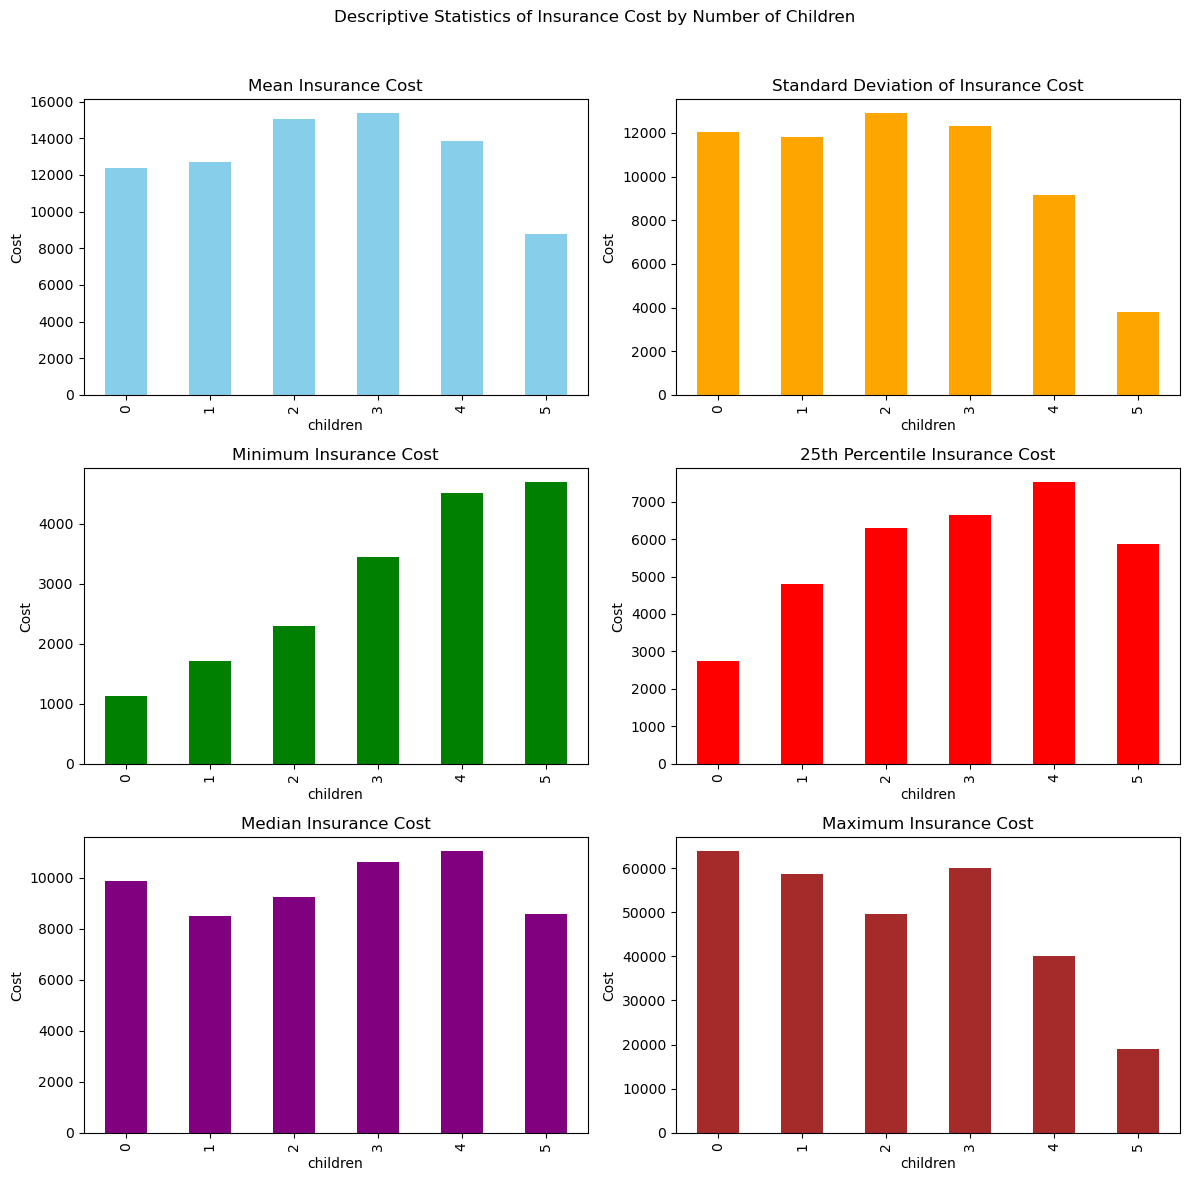

In [18]:
stats = df.groupby('children')['insurance_cost'].describe()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12)) 
fig.suptitle('Descriptive Statistics of Insurance Cost by Number of Children')

stats['mean'].plot(ax=axes[0, 0], kind='bar', color='skyblue', title='Mean Insurance Cost')
axes[0, 0].set_ylabel('Cost')

stats['std'].plot(ax=axes[0, 1], kind='bar', color='orange', title='Standard Deviation of Insurance Cost')
axes[0, 1].set_ylabel('Cost')

stats['min'].plot(ax=axes[1, 0], kind='bar', color='green', title='Minimum Insurance Cost')
axes[1, 0].set_ylabel('Cost')

stats['25%'].plot(ax=axes[1, 1], kind='bar', color='red', title='25th Percentile Insurance Cost')
axes[1, 1].set_ylabel('Cost')

stats['50%'].plot(ax=axes[2, 0], kind='bar', color='purple', title='Median Insurance Cost')
axes[2, 0].set_ylabel('Cost')

stats['max'].plot(ax=axes[2, 1], kind='bar', color='brown', title='Maximum Insurance Cost')
axes[2, 1].set_ylabel('Cost')

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

## Data Preparation

### Creating a Target Variable
Replace the column `insurance_cost` with a binary column `insurance_cost_binary`, where `insurance_cost_binary` is 0 if the corresponding `insurance_cost` is less than or equal to the median insurance cost and 1 otherwise

In [19]:
df['insurance_cost_binary'] = (df['insurance_cost'] > df['insurance_cost'].median()).astype(int)
df.drop(columns=['insurance_cost'], inplace=True)

In [20]:
y = df['insurance_cost_binary']
X = df.drop('insurance_cost_binary', axis=1)

Confirm the change.

In [21]:
df.describe()

age          bmi     children  insurance_cost_binary
count  1338.000000  1338.000000  1338.000000            1338.000000
mean     39.207025    30.663397     1.094918               0.500000
std      14.049960     6.098187     1.205493               0.500187
min      18.000000    15.960000     0.000000               0.000000
25%      27.000000    26.296250     0.000000               0.000000
50%      39.000000    30.400000     1.000000               0.500000
75%      51.000000    34.693750     2.000000               1.000000
max      64.000000    53.130000     5.000000               1.000000

In [22]:
df.head()

age  gender     bmi  children smoker     region  insurance_cost_binary
0   18    male  33.770         1     no  southeast                      0
1   18    male  34.100         0     no  southeast                      0
2   18  female  26.315         0     no  northeast                      0
3   18  female  38.665         2     no  northeast                      0
4   18  female  35.625         0     no  northeast                      0

In [23]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost_binary
1333   64  female  31.825         2     no  northeast                      1
1334   64  female  26.885         0    yes  northwest                      1
1335   64    male  26.410         0     no  northeast                      1
1336   64    male  36.960         2    yes  southeast                      1
1337   64    male  23.760         0    yes  southeast                      1

In [24]:
df['insurance_cost_binary'].value_counts()

0    669
1    669
Name: insurance_cost_binary, dtype: int64

Now we can split the dataset into a training set and a test sets. **Side-note:** the question of splitting the data before came up in the forums. Nik suggested that we follow the tutorials even though the order might cause a problem (biasing our preprocessing decisions).

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

## Creating Pipelines

Here we prepare scikit-learn pipelines for data preparation (preprocessing pipeline), which we apply later. The use of this pipeline ensures that preprocessing is applied separately to each training, validation, and test dataset, preventing data leakage. I will create a pipeline per classifier. The reason for this is that different classifiers may have different requirements.

**Note:** ideally, if this were to be used with new data, the pipelines should include proper imputation. In the interests of brevity (as I have more than one pipeline) I will omit this here. Also, the sample data set does not have missing data. 

In [26]:
def build_preprocessing_pipeline_mk2(for_mlp=False, for_svm=False, for_rf=False, for_logreg=False):

    """
        Feedback from Pierce Currid - create a function to house this 
        (https://learn.ul.ie/d2l/le/17939/discussions/threads/39807/View)

        Decide on scaling based on the model type - this is important. 

        I am using a passthru (or unity) scalar for random forest as 
        this should not matter.
    """

    def log_transform(x):
        return np.log(x + 1)

    if for_rf:
        # No scaling for Random Forest
        scaler = FunctionTransformer(lambda x: x, validate=False)
    else:
        # MinMaxScaler for MLP, SVM, and Logistic Regression
        scaler = MinMaxScaler()
    
    # Using a common transformation for categorical variables
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary'))
    ])

    # Column transformer to apply these transformations to specific columns
    preprocessing_pipeline = ColumnTransformer([
        ('cat', categorical_transformer, ['gender', 'smoker', 'region']),
        ('num', scaler, ['age', 'children', 'bmi'])
    ], remainder='passthrough')

    return preprocessing_pipeline

#### Support Vector Machine (SVM) Pipeline

In [27]:
svm_preprocessor = build_preprocessing_pipeline_mk2(for_svm=True)

#### Random Forest Pipeline

In [28]:
random_forest_preprocessor = build_preprocessing_pipeline_mk2(for_rf=True)

#### Logistic Regression Pipeline

In [29]:
logistic_regression_preprocessor = build_preprocessing_pipeline_mk2(for_logreg=True)

#### MLP Classifier Pipeline 

In [30]:
mlp_preprocessor = build_preprocessing_pipeline_mk2(for_mlp=True)

## Model Training



### SVM
Next, we train an SVM classification model with the training set and a range of possible parameters in order to find the best parameters for SVM by cross-validation. To do this we build another pipeline, the `main pipeline`, which includes the preprocessing pipeline and the SVM classifier. The pipeline takes care of separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation.

In [31]:
from sklearn.decomposition import PCA
pipe = Pipeline(steps=[
    ('preprocess', svm_preprocessor),  
    ('reduce_dim', 'passthrough'),
    ('svm', SVC(probability=True))
])

Visualise the pipeline

In [32]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'smoker',
                                                   'region']),
                                                 ('num', MinMaxScaler(),
                                                  ['age', 'children',
                                                   'bmi'])])),
                ('reduce_dim', 'passthrough'), ('svm', SVC(probability=True))])

Now, let's train the model by exploring various combinations of values of the parameters of the predictor, i.e. SVM. Note that we can also add the parameters of the transformers (the ones included in the preprocessing pipeline) to the parameter grid.

In [33]:
N_FEATURES_OPTIONS = [1,2,3,4,5,6,7,8,9]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'svm__C': [0.01, 0.1, 1, 10, 100],  
        'svm__gamma': [1, 0.1, 0.01, 0.001], 
        'svm__kernel': ['rbf', 'linear', 'poly']
    },
    {
        'reduce_dim': [RFE(estimator=RandomForestClassifier())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'svm__C': [0.01, 0.1, 1, 10, 100],  
        'svm__gamma': [1, 0.1, 0.01, 0.001], 
        'svm__kernel': ['rbf', 'linear', 'poly']
    },
    {
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'svm__C': [0.01, 0.1, 1, 10, 100],  
        'svm__gamma': [1, 0.1, 0.01, 0.001], 
        'svm__kernel': ['rbf', 'linear', 'poly']
    },
    {
        'svm__C': [0.01, 0.1, 1, 10, 100],  
        'svm__gamma': [1, 0.1, 0.01, 0.001], 
        'svm__kernel': ['rbf', 'linear', 'poly']        
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ")

markdown_table = generate_markdown_table([search.best_params_])
display(Markdown(markdown_table))

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.936:
Best parameters: 


| reduce_dim | reduce_dim__n_components | svm__C | svm__gamma | svm__kernel |
| ------------------------------ | ------------------------------------------------------------------------ | ------------------ | ------------------------------ | --------------------------------- |
| PCA(iterated_power=7) | 6 | 100 | 1 | rbf | 


The parameter `refit=True` makes the GridSearchCV train an SVM model on the **whole training set** with the best parameters found. This best SVM model can then be accessed via the `.best_estimator_` attribute of the GridSearchCV.

### Random Forest

Let's repeat the same experiment but with the Random Forest classifier.

Create the pipeline

In [34]:
pipe = Pipeline(steps=[
    ('preprocess', random_forest_preprocessor), 
    ('reduce_dim', 'passthrough'),  # Placeholder for dimensionality reduction
    ('rf', RandomForestClassifier())
    ]
)

Visualise the pipeline

In [35]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'smoker',
                                                   'region']),
                                                 ('num',
                                                  FunctionTransformer(func=<function build_preprocessing_pipeline_mk2.<locals>.<lambda> at 0x378220680>),
                                                  ['age', 'children',
                                                   'bmi'])])),
                ('reduce_dim', 'passthrough'),
                ('rf', RandomForestClassifier())])

Now, let's train the model by exploring various combinations of values of the parameters of the predictor, i.e. Random Forest.

In [36]:
# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'rf__n_estimators': [10, 20, 30, 40, 50],
        'rf__max_depth': [2, 4, 6, 8, 10]
    },
    {
        'reduce_dim': [RFE(estimator=RandomForestClassifier())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'rf__n_estimators': [10, 20, 30, 40, 50],
        'rf__max_depth': [2, 4, 6, 8, 10]
    },
    {
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'rf__n_estimators': [10, 20, 30, 40, 50],
        'rf__max_depth': [2, 4, 6, 8, 10]
    },
    {
        'rf__n_estimators': [10, 20, 30, 40, 50],
        'rf__max_depth': [2, 4, 6, 8, 10]
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ")

markdown_table = generate_markdown_table([search.best_params_])
display(Markdown(markdown_table))

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.939:
Best parameters: 


| reduce_dim | reduce_dim__n_features_to_select | rf__max_depth | rf__n_estimators |
| ------------------------------ | ------------------------------------------------------------------------------------------------ | --------------------------------------- | ------------------------------------------------ |
| RFE(estimator=RandomForestClassifier()) | 6 | 10 | 20 | 


### Logistic Regression

In [37]:
pipe = Pipeline(steps=[
    ('preprocess', logistic_regression_preprocessor), 
    ('reduce_dim', 'passthrough'),  # Placeholder for dimensionality reduction
    ('lr', LogisticRegression(max_iter=1000))
    ]
)

In [38]:
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'lr__C': [0.01, 0.1, 1.0, 10.0, 100.0],  # Different regularization strengths
        'lr__solver': ['liblinear', 'saga', 'newton-cholesky']  # Different solvers
    },
    {
        'reduce_dim': [RFE(estimator=RandomForestClassifier())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'lr__C': [0.01, 0.1, 1.0, 10.0, 100.0],  # Different regularization strengths
        'lr__solver': ['liblinear', 'saga', 'newton-cholesky']  # Different solvers
    },
    {
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'lr__C': [0.1, 1.0, 10.0, 100.0],  # Different regularization strengths
        'lr__solver': ['liblinear', 'saga', 'newton-cholesky']  # Different solvers
    },
    {
        'lr__C': [0.01, 0.1, 1.0, 10.0, 100.0],  # Different regularization strengths
        'lr__solver': ['liblinear', 'saga', 'newton-cholesky']  # Different solvers - saga requires same scale
    }    
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ")

markdown_table = generate_markdown_table([search.best_params_])
display(Markdown(markdown_table))

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.922:
Best parameters: 


| lr__C | lr__solver | reduce_dim | reduce_dim__n_features_to_select |
| --------------- | ------------------------------ | ------------------------------ | ------------------------------------------------------------------------------------------------ |
| 0.01 | saga | RFE(estimator=RandomForestClassifier()) | 4 | 


### MLP Classifier

In [39]:
pipe = Pipeline(steps=[
    ('preprocess', mlp_preprocessor), 
    ('reduce_dim', 'passthrough'),  # Placeholder for dimensionality reduction
    ('mlp', MLPClassifier(max_iter=5000))
    ]
)

I added a third layer based on Pierce Currid's work [here](https://learn.ul.ie/d2l/le/17939/discussions/threads/39893/View).

In [40]:
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'mlp__hidden_layer_sizes': [(10,), (20,), (50, ), (20, 20), (20, 20, 20)], 
        'mlp__activation': ['relu', 'tanh', 'logistic'],  
        'mlp__solver': ['adam', 'sgd'], 
        'mlp__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1] 
    },
    {
        'reduce_dim': [RFE(estimator=RandomForestClassifier())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'mlp__hidden_layer_sizes': [(10,), (20,), (50, ), (20, 20), (20, 20, 20)], 
        'mlp__activation': ['relu', 'tanh', 'logistic'],  
        'mlp__solver': ['adam', 'sgd'], 
        'mlp__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1] 
    },
    {
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'mlp__hidden_layer_sizes': [(10,), (20,), (50, ), (20, 20), (20, 20, 20)], 
        'mlp__activation': ['relu', 'tanh', 'logistic'],  
        'mlp__solver': ['adam', 'sgd'], 
        'mlp__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1] 
    },
    {
        'mlp__hidden_layer_sizes': [(10,), (20,), (50, ), (20, 20), (20, 20, 20)], 
        'mlp__activation': ['relu', 'tanh', 'logistic'],  
        'mlp__solver': ['adam', 'sgd'], 
        'mlp__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]       
    }        
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ")

markdown_table = generate_markdown_table([search.best_params_])
display(Markdown(markdown_table))

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

Best CV score = 0.945:
Best parameters: 


| mlp__activation | mlp__alpha | mlp__hidden_layer_sizes | mlp__solver | reduce_dim | reduce_dim__n_components |
| --------------------------------------------- | ------------------------------ | --------------------------------------------------------------------- | --------------------------------- | ------------------------------ | ------------------------------------------------------------------------ |
| tanh | 1e-05 | (20, 20, 20) | adam | PCA(iterated_power=7) | 7 | 


## Compare Classification Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their results (accuracy, precision, recall, etc.) to choose the better classifier for our problem.

The evaluation function below evaluates a model on a test data set. Note that, the preprocessing pipeline is automatically applied to the test set. The results returned by the function are a variety of metrics measured on the test set which we will use to compare the models and decide which classifier to choose for training the final model. These metrics are:

- accuracy
- precision
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

Before we go further though, it's a good idea to define what these are: 

### Accuracy:
Accuracy measures how often the model makes the correct prediction. It's the ratio of the number of correct predictions to the total number of predictions made (e.g. an accuracy of 90% means that 9 out of 10 predictions are expected to be correct).

The following diagram illustrates the relationship between True Positive (TP), True Negative (TN), False Positive (FP) and False Negative (FN).

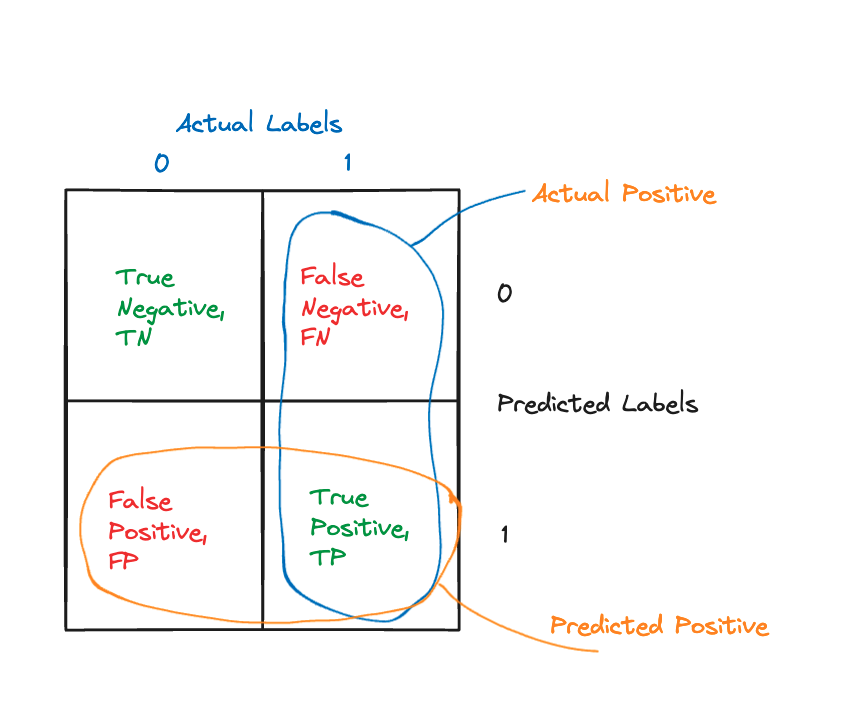

### Recall (Sensitivity):
Recall is the measure of our model's ability to identify all relevant instances within a dataset. It's the ratio of the number of true positives to the sum of the number of true positives and the number of false negatives. High recall indicates the class is correctly recognised (a small number of false negatives).

$$
recall = \frac{TP}{\text{Actual Positive}} = \frac{TP}{TP + FN}
$$

A classifier that has a recall close to 1 has almost no false negatives.

### Precision:
Precision is the ratio of true positives to the sum of true positives and false positives. High precision relates to the low false positive rate, meaning that when the model predicts a positive result, it is likely to be correct.

$$
precision = \frac{TP}{\text{Predicted Positive}} = \frac{TP}{TP + FP}
$$

A classifier with a precision close to 1.0 has almost no false positives. 

### F1-Score:
The F1-score is a measure that combines precision and recall into a single metric by taking their harmonic mean (which gives more weight to low values of either precision or recall). It is  useful when the costs of false positives and false negatives are roughly equal, or when we have an imbalanced class distribution. An F1-score reaches its best value at 1 (perfect precision and recall) and worst at 0.

$$
F_1 = \frac{TP}{TP + \frac{FN+FP}{2}}
$$

To plot ROC curves for the models, we need to ensure that the same false positive rate (fpr) scale is used for all curves. For this reason, we take a scale of 100 equally spaced fpr values between 0 and 1 and interpolate the true positive rate (tpr) for them.

In [41]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the model predicts probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):

    _probabilities = model.predict_proba(X_test)[:, 1]
     
    _predicted_values = model.predict(X_test)
        
    _accuracy = accuracy_score(y_test, _predicted_values)

    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    _fpr, _tpr, thresholds = roc_curve(y_test, _probabilities)
        
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])

    _auc = auc(_fpr, _tpr)

    # Calculate FN and FP across the thresholds
    fn_rate = 1 - _tpr  # FN rate is simply 1 - TPR
    fp_rate = _fpr      # FP rate is equivalent to FPR
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc, thresholds, fn_rate, fp_rate

Now we use the function above to evaluate the best SVM and Random Forest models found by the grid search.

In [42]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc, SVM_thresholds, SVM_fn_rate, SVM_fp_rate = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc,RF_thresholds, RF_fn_rate, RF_fp_rate = evaluate_model(X_test, y_test, RF_best_model)
LR_accuracy, LR_precision, LR_recall, LR_f1_score, LR_tpr, LR_auc,  LR_thresholds, LR_fn_rate, LR_fp_rate = evaluate_model(X_test, y_test, LR_best_model)
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, MLP_auc,  MLP_thresholds, MLP_fn_rate, MLP_fp_rate = evaluate_model(X_test, y_test, MLP_best_model)

In [43]:
display_bold_text("SVM Classification Report:")
markdown_table = generate_markdown_table([SVM_best_params])
display(Markdown(markdown_table))
print(classification_report(y_test, SVM_best_model.predict(X_test)))

display_bold_text("Random Forest Classification Report:")
markdown_table = generate_markdown_table([RF_best_params])
display(Markdown(markdown_table))
print(classification_report(y_test, RF_best_model.predict(X_test)))

display_bold_text("Logistic Regression Classification Report:")
markdown_table = generate_markdown_table([LR_best_params])
display(Markdown(markdown_table))
print(classification_report(y_test, LR_best_model.predict(X_test)))

display_bold_text("MLP Classification Report:")
markdown_table = generate_markdown_table([MLP_best_params])
display(Markdown(markdown_table))
print(classification_report(y_test, MLP_best_model.predict(X_test)))

**SVM Classification Report:**

| reduce_dim | reduce_dim__n_components | svm__C | svm__gamma | svm__kernel |
| ------------------------------ | ------------------------------------------------------------------------ | ------------------ | ------------------------------ | --------------------------------- |
| PCA(iterated_power=7) | 6 | 100 | 1 | rbf | 


              precision    recall  f1-score   support

           0       0.92      0.97      0.94       134
           1       0.97      0.91      0.94       134

    accuracy                           0.94       268
   macro avg       0.94      0.94      0.94       268
weighted avg       0.94      0.94      0.94       268



**Random Forest Classification Report:**

| reduce_dim | reduce_dim__n_features_to_select | rf__max_depth | rf__n_estimators |
| ------------------------------ | ------------------------------------------------------------------------------------------------ | --------------------------------------- | ------------------------------------------------ |
| RFE(estimator=RandomForestClassifier()) | 6 | 10 | 20 | 


              precision    recall  f1-score   support

           0       0.92      0.98      0.95       134
           1       0.98      0.91      0.94       134

    accuracy                           0.94       268
   macro avg       0.95      0.94      0.94       268
weighted avg       0.95      0.94      0.94       268



**Logistic Regression Classification Report:**

| lr__C | lr__solver | reduce_dim | reduce_dim__n_features_to_select |
| --------------- | ------------------------------ | ------------------------------ | ------------------------------------------------------------------------------------------------ |
| 0.01 | saga | RFE(estimator=RandomForestClassifier()) | 4 | 


              precision    recall  f1-score   support

           0       0.88      0.96      0.92       134
           1       0.96      0.87      0.91       134

    accuracy                           0.92       268
   macro avg       0.92      0.92      0.92       268
weighted avg       0.92      0.92      0.92       268



**MLP Classification Report:**

| mlp__activation | mlp__alpha | mlp__hidden_layer_sizes | mlp__solver | reduce_dim | reduce_dim__n_components |
| --------------------------------------------- | ------------------------------ | --------------------------------------------------------------------- | --------------------------------- | ------------------------------ | ------------------------------------------------------------------------ |
| tanh | 1e-05 | (20, 20, 20) | adam | PCA(iterated_power=7) | 7 | 


              precision    recall  f1-score   support

           0       0.91      0.99      0.95       134
           1       0.99      0.90      0.95       134

    accuracy                           0.95       268
   macro avg       0.95      0.95      0.95       268
weighted avg       0.95      0.95      0.95       268



We use a Pandas bar plot to compare the accuracies of both models as well as their precision, recall and F1-score for class 1. 

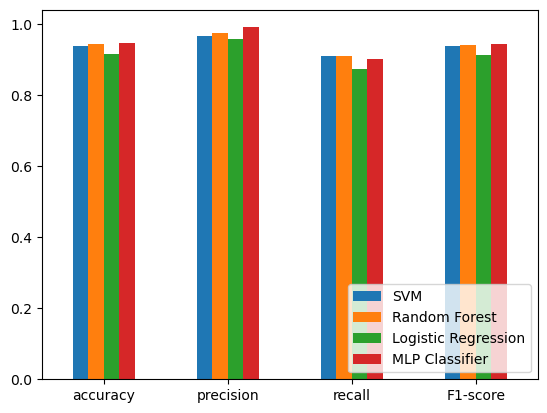

In [44]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
LR_metrics = np.array([LR_accuracy, LR_precision, LR_recall, LR_f1_score])
MLP_Metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])

index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'Logistic Regression': LR_metrics, 'MLP Classifier': MLP_Metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

We can also show the confusion matrices for these trained models.

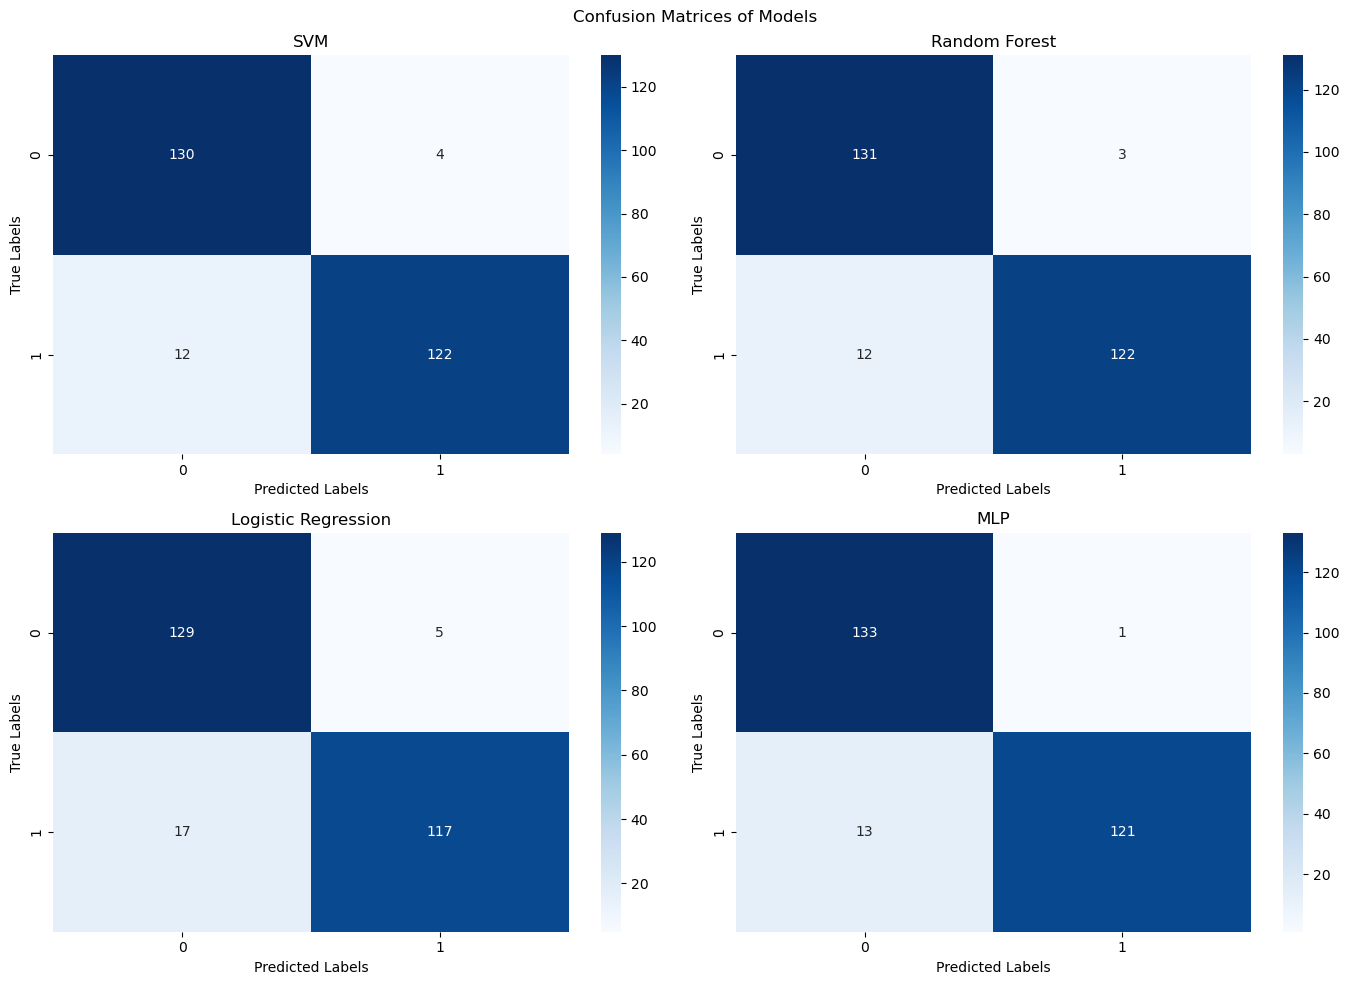

In [45]:
from sklearn.metrics import confusion_matrix

models = {
    'SVM': SVM_best_model,
    'Random Forest': RF_best_model,
    'Logistic Regression': LR_best_model,
    'MLP': MLP_best_model
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Confusion Matrices of Models')

for ax, (label, model) in zip(axes.flatten(), models.items()):
    # Predict the test set
    y_pred = model.predict(X_test)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(label)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

plt.tight_layout()
plt.show()

These classifiers have a relatively high number of false negatives, compared to false psoitves (i.e. recall is lower than precision).

We can also examine the ROC curves of the models for class 1.

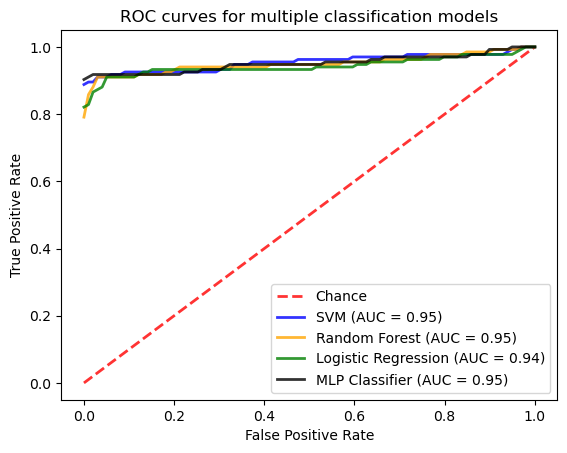

In [46]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)

plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, LR_tpr[0,:], lw=2, color='green', label='Logistic Regression (AUC = %0.2f)' % (LR_auc), alpha=0.8)
plt.plot(mean_fpr, MLP_tpr[0,:], lw=2, color='black', label='MLP Classifier (AUC = %0.2f)' % (MLP_auc), alpha=0.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classification models')
plt.legend(loc="lower right")
plt.show()

The ROC curves confirm that all classification models perform significantly better than a random guess (the red dashed `no skill` line). Random Forest edges ahead, in terms of the AUC.  

**Ideally, the code could be enhanced to run the entire experiment multiple times and average the results.**

## Train the Final Model

Finally, we can train a model with all data we have, assuming that the more data we have the better the model.

In [47]:
final_model = MLP_best_model.fit(X, y)

We can also store this model on disk and deploy later within a software system.

In [48]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

## Analysis 
All models perform relatively well, showing good performance. But, the "stand-out" models are the MLP Classifier and the Random Forest Classifier. Of the two, MLP tends to perform better but takes far more time to train.

Considering the previous classification reports, the ROC charts and the model performance metrics, the following conclusions could be drawn (**Note that the figures tend to change every time I run as I have a random component**).

### Accuracy:
The accuracy, in decreasing order, is as follows: **MLP**, **SVM**, **Random Forest** and **Linear Regression**.

### Precision
Precision, in decreasing order is: **MLP**, **Random Forest**, **SVM** and **Linear Regression:**.

### Recall
**MLP/SVM** have the best recall (lowest number of false negatives), then **Random Forest** and finally **Logistic regression** has a recall $\approx$0.85 (a relatively high number of false negatives). 

### f1-score
**MLP:**, **Random Forest**, **SVM:** and **Linear Regression:**.

**Receiver Operating Characteristic (ROC) Curves**:
- The ROC curves show that all models perform far better than chance (indicated by the diagonal dashed red line).
- The high elbow on the curves top-left corner indicates relatively high true positive rates and low false positive rates for all models. This is a great visual characteristic to take note of.

**Overall Model Comparison**:
- The performance chart directly compares the models' accuracy, precision, recall, and F1-scores. It's evident that while RandomForest and MLP are closely matched across all metrics, MLP has the slight edge in accuracy, precision and F1-scores (precision/recall).
- SVM follows with excellent accuracy and f1 scores.
- Logistic Regression, while having a good AUC, falls behind in the other metrics. It's our worst (relatively) performing model; but still OK.
- We will see later that these models are quite conservative, with more false negatives than false positives. Appendix 1 delves into the notion of using precision and recall to better understand the behaviour of the classifier. We can tune this a little. 

## Conclusion

Regarding pre-processing, I am using a very simple preprocessing strategy overall: keeping the bmi and children as-is as I believe there is data here (no evidence of errorenous or invalid outliers). Having said that, proper scaling of the data is very important. It is worth noting that I observe that Random Forest does better if I don't scale the numeric variables. All other classifiers have a MinMaxScaler on the numerical fields. 

As shown, accuracy on its own might be misleading (the other metrics give us insight into potential flaws in the trained model). Utlimately, the choice of model depends on specific trade-offs regarding the subject matter. It's important to consider the totality of the classification reports and ROCs in the context of the business use case. For example, biometric verification applications might accept certain kinds of failures more than others (e.g. a notion of False Acceptance and Rejection Rates (FAR/FRR) where they say it is better to deny a valid person access to a system than given an unauthorised person access to a system). 

For an insurance system we could consider recall, precision, f1 and accuracy as follows:

   - **Precision:** predicts someone as being a good candidate when they really are. If this is high, then there's less chance of a loss for the business (as opposed to constantly giving insurance to high risk individuals).
   - **Recall:** a high recall means we have a model that tries to minimise the failure to insure good candidates  (see equation above and the relationship to false negatives).
   - **F1 Score:** helps to understand if we have a precision or recall issue. It will be lower if one of these is low (a low f1 score should cause us to consider recall and precision in the use case context). 
   - **Accuracy:** a high accuracy means the model is good at identifying candidates we should and should not insure.   

**In an insurance use-case, precision is probably the most important metric as it could cause significant loss for the business (whereas, in a medical context a false negative might be a more important metric). With that in mind, the MLP classifier is our best bet. But, even at that, the business has to define the thresholds required for the balance between TPR and FPR.**

## Rubrik Checklist

- Created preprocessing pipeline - investigated outliers and focused on scaling
- All models trained with pipelines (including dimension reduction techniques - each gridsearch included a no-dim reduction option to determine if dimensiotn reduction actually caused an issue)
- Pipelines are the source of all processing, dim reduction and classification - no extraneous steps other than the initial addition of the new column for the target variable
- Binarised the insurance_cost variable
- Added PCA, RFE and SelectKBest dimension reduction techniques
- Grid search used a range of hyperparameter option (BayesSearch would be an avenue to investigate - given the training and eval times)
- Use 4 classifiers: MLP, SVM, Random Forest and linear regression
- Model evaluation - ROC, precision-recall curves and discussion precision, recall and fscore. I likely spent too much time on this but, from experience know this is important and so used the time to delve into it.

# References
- [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)
- Guerbai, Y., Chibani, Y. and Hadjadji, B. (2014) “The effective use of the one-class SVM classifier for handwritten signature verification based on writer-independent parameters.” Available at: https://doi.org/10.1016/j.patcog.2014.07.016.

# Appendices

## Appendix 1: Using Precision Instead of Just Relying on Accuracy (especially in imbalanced datasets)
Our data set is pretty balanced, in tems of class division and the test accuracies for all classifiers are all above 0.9 which is good. Having said that, we might think we are done once we have a high test accuracy. But, depending on the dastasets, precision and recall can be important too. Especially in understanding the potential for false negatives and false positives (which are a more fine-grained explaination of errors in the classifier behaviour (Guerbai et al. 2014)). 

This sections "digs" into the idea of managing the balance between false positives and false negatives; to find a threshold that balances our domains' precision-recall requirements. 

In [49]:
from sklearn.metrics import precision_recall_curve
required_precision = 0.99 #Consider this is the required precision

We can also plot Precision-Recall Curves for classifiers

In [50]:
svm_probs = SVM_best_model.predict_proba(X_test)[:, 1]
rf_probs = RF_best_model.predict_proba(X_test)[:, 1]
lr_probs = LR_best_model.predict_proba(X_test)[:, 1]
mlp_probs = MLP_best_model.predict_proba(X_test)[:, 1]

In [51]:
svm_precision, svm_recall, svm_thresholds = precision_recall_curve(y_test, svm_probs)
rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_test, rf_probs)
lr_precision, lr_recall, lr_thresholds = precision_recall_curve(y_test, lr_probs)
mlp_precision, mlp_recall, mlp_thresholds = precision_recall_curve(y_test, mlp_probs)

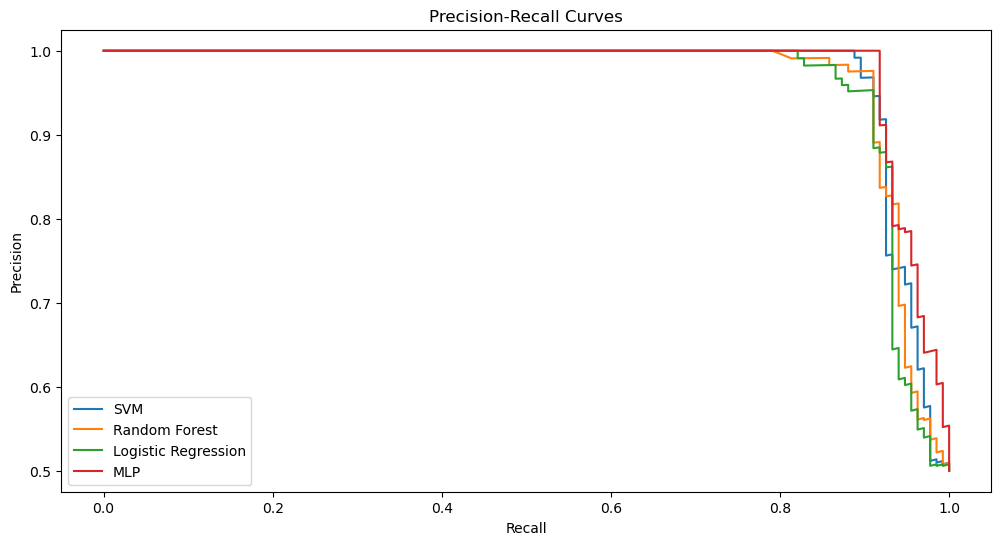

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(svm_recall, svm_precision, label='SVM')
plt.plot(rf_recall, rf_precision, label='Random Forest')
plt.plot(lr_recall, lr_precision, label='Logistic Regression')
plt.plot(mlp_recall, mlp_precision, label='MLP')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

- **MLP:** maintains a maximum precision and has the best overall precision/recall characteristic.
- **Random Forest:** follows with the next best precision/recall characteristic
- **SVM** has the next best precision/recall characteristic
- **Logistic Regression:** precision drops off earlier than others

#### And Visualise the Impact of Precision-focused thresholds on classifier behaviour

The following plots show each classifiers' behaviour for the ```required_precision```. Everything on the right of the red line is deemed to be positive (including false postives) and everything on the left is deemed to be negative (including false negatives).

In [53]:
def find_threshold_for_precision(precision, thresholds, required_precision=0.95):
    """
    Find the lowest threshold that gives at least the required precision
    """

    idx = np.where(precision >= required_precision)[0][0]
    return thresholds[idx]

In [54]:
svm_threshold = find_threshold_for_precision(svm_precision, svm_thresholds, required_precision)
rf_threshold = find_threshold_for_precision(rf_precision, rf_thresholds, required_precision)
lr_threshold = find_threshold_for_precision(lr_precision, lr_thresholds, required_precision)
mlp_threshold = find_threshold_for_precision(mlp_precision, mlp_thresholds, required_precision)

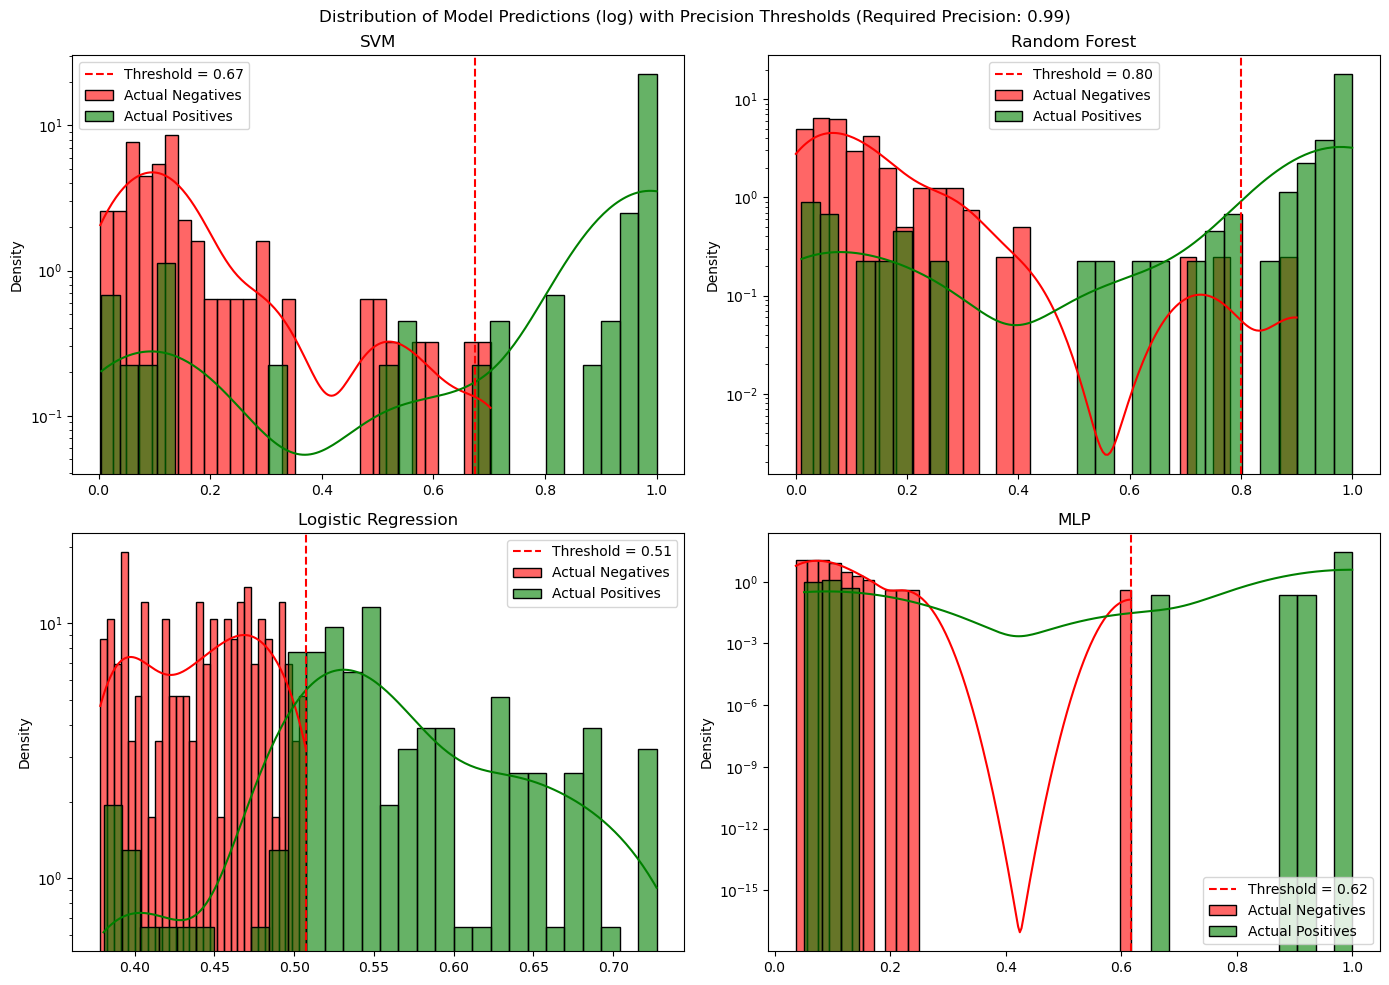

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Distribution of Model Predictions (log) with Precision Thresholds (Required Precision: {required_precision:.2f})')

model_data = [
    (svm_probs, svm_threshold, 'SVM', axes[0, 0]),
    (rf_probs, rf_threshold, 'Random Forest', axes[0, 1]),
    (lr_probs, lr_threshold, 'Logistic Regression', axes[1, 0]),
    (mlp_probs, mlp_threshold, 'MLP', axes[1, 1])
]

for probs, threshold, label, ax in model_data:
    # Filter out the actual negatives
    sns.histplot(probs[y_test == 0], kde=True, stat="density", bins=30, ax=ax, color='red', label='Actual Negatives', alpha=0.6)
    
    # and the actual positives
    sns.histplot(probs[y_test == 1], kde=True, stat="density", bins=30, ax=ax, color='green', label='Actual Positives', alpha=0.6)
    
    ax.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.2f}')
    ax.set_yscale('log')  # Logarithmic scale
    ax.set_title(label)
    ax.legend()

plt.tight_layout()
plt.show()

Each plot corresponds to one of the models, regarding the distribution of their predictions and the location of the threshold that achieves at least ```required_precision``` (when we deploy these models, we can always tweak this but know that it will impact performance). 

The red dashed line in each plot indicates the threshold level where the model achieves the ```required_precision```. This visual aid is crucial for understanding how conservative (or risk-averse) each model is in classifying an instance as positive to ensure the required precision. The red threshold line marks the decision point where we make a trade-off on the number of false positives and false negatives that we are willing to accept.  That is, if you move the threshold left or right, you're making a choice about what you consider are positive and  negative classifications (and this impacts False Negatives and False Positives - you let more or less "bad" decisions through the net). We can see that the threshold for the MLP classifier delivers the least false positives (but this also increases the positibility of false negatives). 

All this highlights the idea that, while test accuracy is important, when it comes to applying the classifier in practice you need to address (and more than likely explain) the implications of false positives and false negatives in the context of the business. So, in practice, you will need to balance the requirements of the system and so some domain knowledge is required when applying the model.

#### First, let us focus more closely on the best model, MLP
We get the following:

In [56]:
probabilities = final_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probabilities)

In [57]:
final_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'smoker',
                                                   'region']),
                                                 ('num', MinMaxScaler(),
                                                  ['age', 'children',
                                                   'bmi'])])),
                ('reduce_dim', PCA(iterated_power=7, n_components=7)),
                ('mlp',
                 MLPClassifier(activation='tanh', alpha=1e-05,
                               hidden_layer_sizes=(20, 20, 20),
                               max_iter=5000))])

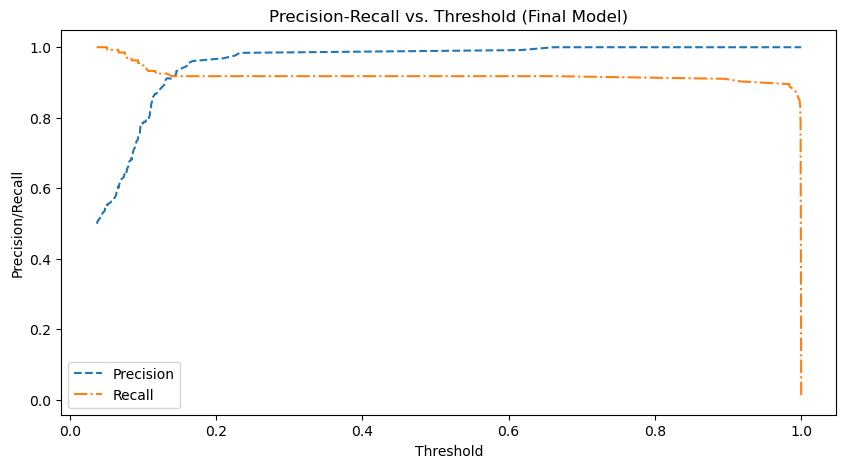

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision[:-1], label="Precision", linestyle='--')
plt.plot(thresholds, recall[:-1], label="Recall", linestyle='-.')
plt.title("Precision-Recall vs. Threshold (Final Model)")
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.legend()
plt.show()

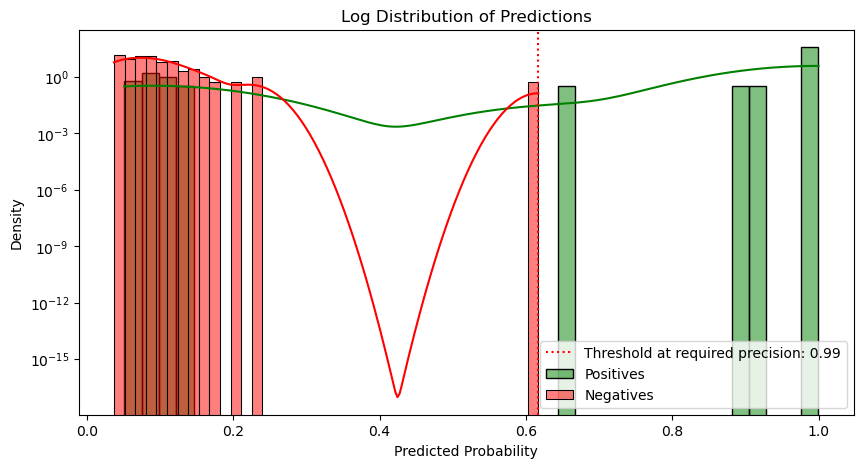

In [59]:
chosen_threshold = find_threshold_for_precision(precision, thresholds, required_precision)

plt.figure(figsize=(10, 5))
sns.histplot(probabilities[y_test == 1], bins=40, color='green', kde=True, stat="density", label='Positives')
sns.histplot(probabilities[y_test == 0], bins=40, color='red', kde=True, stat="density", label='Negatives')

plt.axvline(x=chosen_threshold, color='r', linestyle=':', label=f'Threshold at required precision: {required_precision:.2f}')
plt.annotate(f'Threshold = {chosen_threshold:.2f}', xy=(chosen_threshold, 0), xytext=(chosen_threshold + 0.05, 0.5),
             textcoords='axes fraction', fontsize=10, color='black', horizontalalignment='right')

plt.title("Log Distribution of Predictions")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.yscale('log')  # Logarithmic scale

plt.legend()
plt.show()

In this case, for the required precision, we have almost zero false postives (but we have greatly increased the chance of false negatives). And, if I reduce the required precision down from 0.99, the threshold line mores to the left, allowing more false positives through the net (which decreases the rate of false negatives). It's all about balancing for your domain.

## Appendix 2: Medical Cost Personal Datasets
Insurance Forecast by using Linear Regression.

### Column Descriptions

- **age:** age of primary beneficiary
- **sex:** insurance contractor gender, female, male
- **bmi:** Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- **children:** Number of children covered by health insurance / Number of dependents
- **smoker:** Smoking
- **region:** the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- **charges:** Individual medical costs billed by health insurance